In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Cargar los datos
df = pd.read_csv('youtoxic_english_1000.csv')

# Preprocesar el texto
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Text']).toarray()
y = df['IsToxic'].astype(int).values

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Definir el modelo
class ToxicClassifier(nn.Module):
    def __init__(self, input_size):
        super(ToxicClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Crear el modelo
model = ToxicClassifier(X_train.shape[1])

# Definir la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [3]:
# Entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    
    print(f'Época {epoch+1}/{num_epochs}, Pérdida: {loss.item():.4f}')


Época 1/10, Pérdida: 0.6857
Época 2/10, Pérdida: 0.6398
Época 3/10, Pérdida: 0.4946
Época 4/10, Pérdida: 0.2590
Época 5/10, Pérdida: 0.1023
Época 6/10, Pérdida: 0.0440
Época 7/10, Pérdida: 0.0649
Época 8/10, Pérdida: 0.0444
Época 9/10, Pérdida: 0.0116
Época 10/10, Pérdida: 0.0054


In [4]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = (test_outputs.squeeze() > 0.5).float()
    accuracy = (test_predictions == y_test_tensor).float().mean()
    print(f'Precisión en el conjunto de prueba: {accuracy.item():.4f}')


Precisión en el conjunto de prueba: 0.6900


In [7]:
def predict_toxicity(text):
    # Preprocesar el texto
    text_vectorized = vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_vectorized)
    
    # Hacer la predicción
    model.eval()
    with torch.no_grad():
        prediction = model(text_tensor)
    
    return prediction.item()

# Ejemplo de uso
nuevo_texto = "the live is crazy"
toxicidad = predict_toxicity(nuevo_texto)
print(f"La probabilidad de que el texto sea tóxico es: {toxicidad:.4f}")


La probabilidad de que el texto sea tóxico es: 0.1503


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predictions = (outputs.squeeze() > 0.5).float()
        
        accuracy = accuracy_score(y.numpy(), predictions.numpy())
        precision = precision_score(y.numpy(), predictions.numpy())
        recall = recall_score(y.numpy(), predictions.numpy())
        f1 = f1_score(y.numpy(), predictions.numpy())
        
        print(f'Precisión: {accuracy:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-Score: {f1:.4f}')
        
        cm = confusion_matrix(y.numpy(), predictions.numpy())
        print('Matriz de confusión:')
        print(cm)

# Evaluar en conjunto de entrenamiento y prueba
print("Métricas en conjunto de entrenamiento:")
evaluate_model(model, X_train_tensor, y_train_tensor)
print("\nMétricas en conjunto de prueba:")
evaluate_model(model, X_test_tensor, y_test_tensor)


Métricas en conjunto de entrenamiento:
Precisión: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Matriz de confusión:
[[445   0]
 [  0 355]]

Métricas en conjunto de prueba:
Precisión: 0.6900
Recall: 0.5981
F1-Score: 0.6737
Matriz de confusión:
[[74 19]
 [43 64]]


In [9]:
from sklearn.model_selection import KFold

def cross_validate(X, y, num_folds=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = ToxicClassifier(X.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters())
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs.squeeze(), y_train)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_predictions = (val_outputs.squeeze() > 0.5).float()
            accuracy = (val_predictions == y_val).float().mean()
            accuracies.append(accuracy.item())
        
        print(f'Fold {fold} - Precisión: {accuracy.item():.4f}')
    
    print(f'Precisión media: {sum(accuracies) / len(accuracies):.4f}')

cross_validate(X_train_tensor, y_train_tensor)


Fold 1 - Precisión: 0.5938
Fold 2 - Precisión: 0.5625
Fold 3 - Precisión: 0.6000
Fold 4 - Precisión: 0.5625
Fold 5 - Precisión: 0.5312
Precisión media: 0.5700


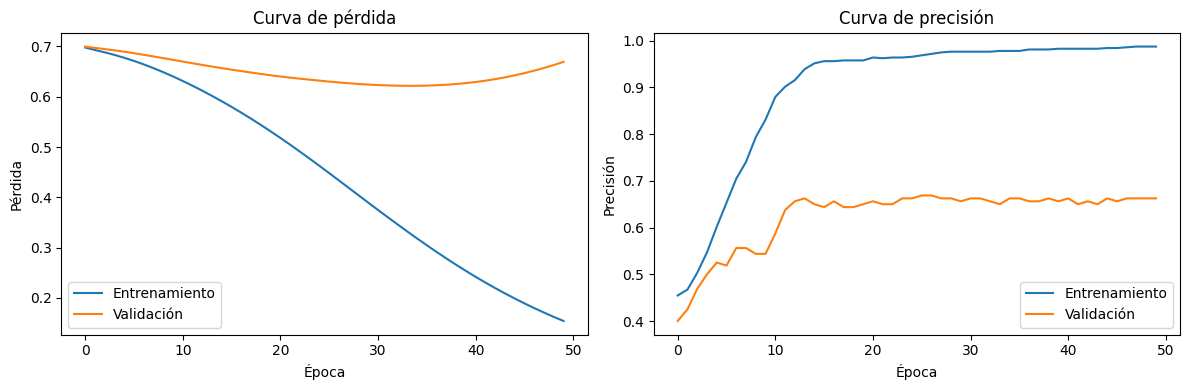

In [10]:
import matplotlib.pyplot as plt

def plot_learning_curves(model, X_train, y_train, X_val, y_val, num_epochs=50):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs.squeeze(), y_train)
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs.squeeze(), y_val)
            
            train_predictions = (train_outputs.squeeze() > 0.5).float()
            val_predictions = (val_outputs.squeeze() > 0.5).float()
            
            train_accuracy = (train_predictions == y_train).float().mean()
            val_accuracy = (val_predictions == y_val).float().mean()
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(val_losses, label='Validación')
    plt.title('Curva de pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Entrenamiento')
    plt.plot(val_accuracies, label='Validación')
    plt.title('Curva de precisión')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

# Crear un nuevo modelo para las curvas de aprendizaje
model_curves = ToxicClassifier(X_train.shape[1])

plot_learning_curves(model_curves, X_train, y_train, X_val, y_val)
